<a href="https://colab.research.google.com/github/john-sedrak/ML-CV-Project/blob/main/DS_ML_Project_Day_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#<center> DS ML Capstone Project: Celebrity Face Recognition


##### <center>Original work: [Sports Celebrity Image Classification — codebasics](https://youtube.com/playlist?list=PLeo1K3hjS3uvaRHZLl-jLovIjBP14QTXc)
##### <center> Prepared by: Ahmed Mokhtar

---

After cleaning our dataset, it is ready for ML. Right?... Well, partially. A good data scientist will always look for ways to manipulate the data in order to bring out the information hidden within it. Extracting meaningful features from the data is called [feature engineering](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/). It is the focus of this notebook. 

As usual, before we start our notebook we will have to load our dataset. If you are storing it on google drive, mount your drive first.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Alternatively, you can use this this pre-prepared dataset:

In [2]:
import shutil
from os import path

if path.exists('./dataset'):
    shutil.rmtree('./dataset')

if path.exists('./dataset-cropped'):
    shutil.rmtree('./dataset-cropped')

!git clone https://github.com/IEEE-GUC-DS/dataset-cropped.git

Cloning into 'dataset-cropped'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 563 (delta 9), reused 25 (delta 9), pack-reused 538
Receiving objects: 100% (563/563), 93.84 MiB | 38.68 MiB/s, done.
Resolving deltas: 100% (11/11), done.


<font color="orange">N.B. You will need to click the refresh button to see any changes in your directory.</font><br>
<center><img src="https://i.imgur.com/2VxcX9E.png" alt="refresh">


## Part IV: Feature Engineering

Follow along with this video as you solve the notebook: [Data Science & Machine Learning Project - Part 4 Feature Engineering | Image Classification](https://www.youtube.com/watch?v=sWAPtaBZKBQ&list=PLeo1K3hjS3uvaRHZLl-jLovIjBP14QTXc&index=4).<br><br>

In this notebook we will be using [wavelet packet decomposition](https://en.wikipedia.org/wiki/Wavelet_packet_decomposition) to get more pronounced edges from the image. This makes it easier for our model to detect face structure. We will use the [PyWavelets](https://pywavelets.readthedocs.io/en/latest/) library to perform the decomposition. 

<mark>Task: Import the needed libraries. Including OpenCV and PyWavelets (import pywt).

In [3]:
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt
%matplotlib inline
import os

Watch this intelligible explanation of the intuition behind wavelet decompositions: [Wavelet Transform Analysis of Images using Python](https://www.youtube.com/watch?v=ExU0izGXgSI).

Key takeaways:


*   The decomposition is achieved by convolving the image with a low pass filter (only low frequencies are allowed), and a high pass filter (only high frequencies are allowed). Then we [downsample](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) the result.
*   High frequencies contain information about the edges (alongside noise).

*   For 2D decompositions, we do a 1D decomposition on one of the axes. Then, we decompose the result on the other axis. This gives us 4 matrices.

*    The approximation coefficient matrix (*cA*) contains the low frequency information of the image. Most of the information present in the image resides here.

*    The horizontal detailed coefficient matrix (*cH*) has information about the horizontal edges.

*    The vertical detailed coefficient matrix (*cV*) has information about the vertical edges.

*    The diagonal detailed coefficient matrix (*cD*) has information about the diagonal edges.

*    Wavelet transform is just a single level wavelet decomposition.<br><br>

So now that we have some intution, what is our plan? How can we leverage wavelet decomposition to extract useful features?

Having a clear representation of edges would be helpful! We can decompose the image to get the 4 coefficient matrices. Subsequently, we can get rid of the *cA* matrix, since we are only concerned about the edges. Finally, we can reconstruct the image back wihout *cA*. Thus, giving us a visualization of the edges present in the original image. Sounds like a solid plan!<br><br>

We are interested in 2 functions from the `pywt` library:



1.   [pywt.wavedec2](https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2): This function takes the image and returns a list. The first element in the list is *cA* (get rid of it by multiplying it with 0). Each one of the remaining elements is tuple containing 3 matrices, the *cHn*, *cVn*, and *cDn*. Where *n* is the current decomposition level. Set the `wavelet` parameter to "db1", and the `level` parameter to 5. **This function only takes grayscale normalized images!**
2.   [pywt.waverec2](https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2): This function takes the coefficient matrices and returns the reconstructed image. Set the `wavelet` parameter to "db1". Remember to scale your reconstruction back (multiply it by 255).

I have given you the recipe, it is your turn to execute!

<mark>Task: Write a function called 'w2d' that takes an image and returns another image that contains information about the edges only.  



In [4]:
def w2d(img):
  wavelet = 'db1'
  gr_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gr_img = np.float32(gr_img)
  gr_img /= 255
  dec_img = pywt.wavedec2(gr_img, wavelet, level=5)
  # print(dec_img[5][2].shape)
  dec_img[0] *= 0
  rec_img = pywt.waverec2(dec_img, wavelet)
  rec_img *= 255
  rec_img = np.uint8(rec_img)
  return rec_img
  


<mark>Task: Test your function on an image from the dataset, and display the result.

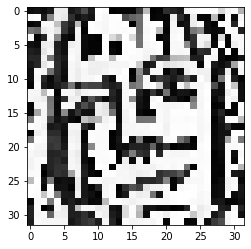

In [11]:
img = cv2.imread('/content/drive/MyDrive/datasets/cropped/jennifer_aniston/13bfcc7be6.jpg')
rec_img = w2d(img)
res_rec_img = cv2.resize(rec_img, (32,32))
plt.imshow(res_rec_img, cmap='Greys')

We now need to apply our method to all the faces in the dataset. However, we need to keep the original faces as well, since they contain features not present in the edge representation. Therefore, we need to stack both images using numpy. We can also notice that the dataset images have varying dimensions. This is bad news for our model! Training on certain image dimensions and testing on unseen dimensions will yield terrible performance. For this reason, we should rescale all the images to uniform dimensions. In the video we chose 32 x 32 for memory and time complexity reasons. One last thing to be careful with is the shape of the data. Each row should be a sample, and each column should be a feature (or a pixel). Therefore we should reshape our samples to make them 1-dimensional.

It is now time to prepare the input of your model, along with the labels (X, y).

<mark>Task: Make a list called 'X' that contains the flattened stacked 32x32 images and the 32x32 edge representations. Make another list called 'y' that contains the labels, assign a number to each of your classes. You should keep track of these numbers in a dictionary.

In [24]:
label_lookup = {}
cr_dir = '/content/drive/MyDrive/datasets/cropped/'
X = []
y = []
i = 0
for dir in os.listdir(cr_dir):
  label_lookup[i] = dir
  person_dir = cr_dir + dir
  
  for path in os.listdir(person_dir):
    img = cv2.imread(person_dir + '/' + path)
    resized_raw_img = cv2.resize(img, (32,32))
    resized_rec_img = cv2.resize(w2d(img), (32,32))
    stacked = np.vstack([resized_raw_img.reshape(-1,1), resized_rec_img.reshape(-1,1)])
    X.append(stacked)
    y.append(i)

  i+=1


<mark>Task: You should convert your lists to numpy arrays. Moreover, you should double check their shapes. The rows should contain the samples, and each column should contain a single feature (pixel). You should have a total of 4096 columns. Finally, convert the X array to type float.

In [25]:
X = np.array(X)
X = X.reshape(140, 4096)
y = np.array(y)
print(X.shape, y.shape)

(140, 4096) (140,)


Saving these variables is helpful for our next notebook. Use the following cell to save them. Then upload the file to your drive.

<font color="orange">N.B. Replace the variable `label_lookup` with the name of the dictionary you used to store label names.</font><br>

In [26]:
import pickle

# Saving the dataset:
with open('./drive/MyDrive/datasets/final_data.pkl', 'wb') as f:
    pickle.dump([X, y, label_lookup], f)

You did it! You have successfully prepared a dataset for ML from scratch. This is not something trivial. In the next notebook, you will finally get to train and evaluate your model on your very own image dataset. This is where you will see the fruits of your labor. But for now, enjoy your day.

You are doing great! (•ᵕ•)/<font color="red">♥</font><br>

<center><img src="https://c.tenor.com/aV2NHR_Vs4wAAAAM/break-breaktime.gif" width="40%">